Created by Luis Rosario

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras.utils import to_categorical, np_utils, plot_model

from keras import optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import warnings, os, datetime
warnings.filterwarnings('ignore')
from IPython.display import Image
from sklearn.model_selection import train_test_split

# Step 1 Load the minst dataset

In [8]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


# Display to images 

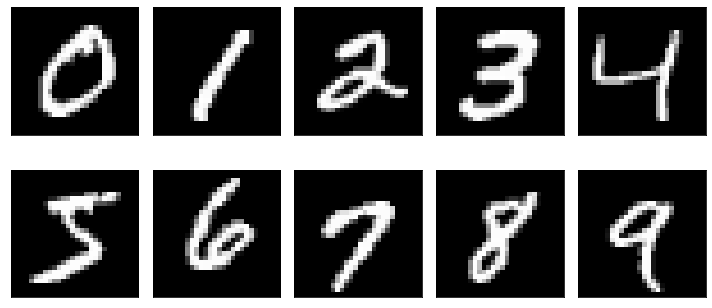

In [9]:
fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(10,5))
for idx, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    for i in range(1000):
        if train_labels[i] == idx:
            ax.imshow(train_images[i],cmap='gray')
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            break
plt.tight_layout()
plt.show()

# Step 2 Reshape and scale the images pixels values

In [10]:
# Reshape the dataset for our neural network
# Normalize range of values between 0 to 1 (from 0 to 255)
X_train_reshaped = train_images.reshape((train_images.shape[0], 
                                    train_images.shape[1]*train_images.shape[2]))/255.
X_test_reshaped = test_images.reshape((test_images.shape[0], 
                                  test_images.shape[1]*test_images.shape[2]))/255.


# Step 3 Functions to plot loss, create model and add AWGN

In [11]:
def graphHistory(history, title='',metrics=['loss'], fontsize=20,
                linewidth=5,figsize=(10,10), tick_size = 5):
    '''Function for graphing the training and valiedation accuracy and loss'''
    
    plt.rc('xtick', labelsize=tick_size) 
    plt.rc('ytick', labelsize=tick_size) 
        
    # Plot history for different metrics 
    for strText in metrics:
        fig = plt.figure()
        plt.figure(figsize = figsize)
        plt.plot(history.history[strText], linewidth=linewidth)
        
        try:
            plt.plot(history.history['val_'+strText],linewidth=linewidth )
            plt.legend(['Tr. '+strText, 'Val. '+strText], 
                       fontsize =fontsize)
        except:
            plt.legend(['Tr. '+strText],fontsize =fontsize)
                        
        plt.title('MODEL '+strText.upper() + title,fontsize =fontsize)
        plt.ylabel(strText.upper(),fontsize=fontsize)
        plt.xlabel('Epoch',fontsize=fontsize)           
        plt.show()


def AWGN(train, snr=0):
    """ Add noise at the desired SNR to each image. Uncomment to see the results of the computations performed"""
    
    # FOr very high noise power the signal is buried under the noise and (S+N)/N doesnt display the correct SNR ratio
    # You need to do (S+N-N)/N or just S/N
    #Signal SNR in linear
    PowS =np.expand_dims(np.mean(train**2, axis = 1),axis=1); 
    Pn = PowS/(10**(snr/10))    #Noise SNR in linear
    
    #Mean zero and unit variance noise vector
    noise = np.random.normal(0, 1, size=train.shape)

    #Mutltiply by the standard deviation to get desiable noise power. 
    noise2 = np.sqrt(Pn)*noise  

    #Add the noise and the signal
    S_N = train + noise2
    
    # Add noise to the MNIST datasets
    X_train_noised = train + noise2
    X_train_noised = np.clip(X_train_noised, a_min=0, a_max=1)
    
    return X_train_noised

def save_model(model, save_dir=os.path.join(os.getcwd(), 'saved_models'),
                   model_file_name='Denoising_AE_model.h5'):
    """
    Save model and current weights
    :param model: Keras model
    :param save_dir: path name to save directory
    :param model_file_name: filename for saved model
    :return: nothing
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)
    
def loadmodel(model_file_name, directory='saved_models'):
    # Load model and weights
    if not os.path.isdir(directory):
        os.makedirs(directory)
    model_path = os.path.join(directory, model_file_name)
    model = load_model(model_path)
    print('Loaded trained model from %s ' % model_path)
    return model

# Step 4 Create a dataset with AWGN ranging from -10 to 10 dB

In [12]:
%%time
# Model Building and Training train the model at -10 db
snr = -10
X_train_noised = AWGN(X_train_reshaped, snr=snr)

for snr in np.arange(-8,10+1,2):
    X_train_noised = np.append(X_train_noised,
                               AWGN(X_train_reshaped, 
                               snr=snr),
                               axis=0)

Wall time: 41.3 s


# Step 5 Split the data into training and validation

In [15]:
#Repeat the flatten mnist digits to create a set of noiseless digits
D = int(X_train_noised.shape[0]/X_train_reshaped.shape[0])
X_train_no_noise = np.tile(X_train_reshaped,(D,1))


#Pass noisy digits as X and noiseless digits as y to the split the data into train/test
x_train_noisy, x_valid_noisy, y_train_no_noise, y_valid_no_noise = train_test_split(
   X_train_noised, X_train_no_noise, test_size=0.1, shuffle= True)

x_train_noisy.shape, x_valid_noisy.shape, y_train_no_noise.shape, y_valid_no_noise.shape

((594000, 784), (66000, 784), (594000, 784), (66000, 784))

# Train the a deeper dense encoder-decoder

In [16]:
def create_deep_autoencoder(hidden_layer_size=[128, 64, 32, 64, 128]):
    model = Sequential()
    model.add(Dense(units=hidden_layer_size[0], input_shape=(784,),
                    activation='relu'))
    model.add(Dense(units=hidden_layer_size[1],  activation='relu'))
    model.add(Dense(units=hidden_layer_size[2],  activation='relu'))
    model.add(Dense(units=hidden_layer_size[3],  activation='relu'))
    model.add(Dense(units=hidden_layer_size[4],  activation='relu'))    
    model.add(Dense(units=784, activation='sigmoid'))
    return model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 

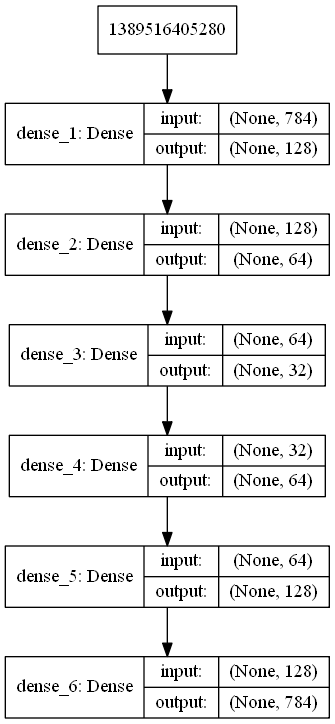

In [17]:
Name = "denosing" #.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
TB = callbacks.TensorBoard(log_dir="logs/{}".format(Name))


#Adding EarlyStopping by monitoring the validation loss
stopEarly = callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                   verbose=0,patience=5)

callback = [stopEarly, TB]

#64,32,16,32,64
model = create_deep_autoencoder(hidden_layer_size=[128,64,32,64,128])
    
#binary_crossentropy
model.compile(optimizer='adam', loss='mean_squared_error')

plot_model(model, show_shapes=True,to_file='autoencoder1.png')
model.summary()
Image(filename='autoencoder1.png') 

Instructions for updating:
Use tf.cast instead.
dict_keys(['val_loss', 'loss'])


<Figure size 432x288 with 0 Axes>

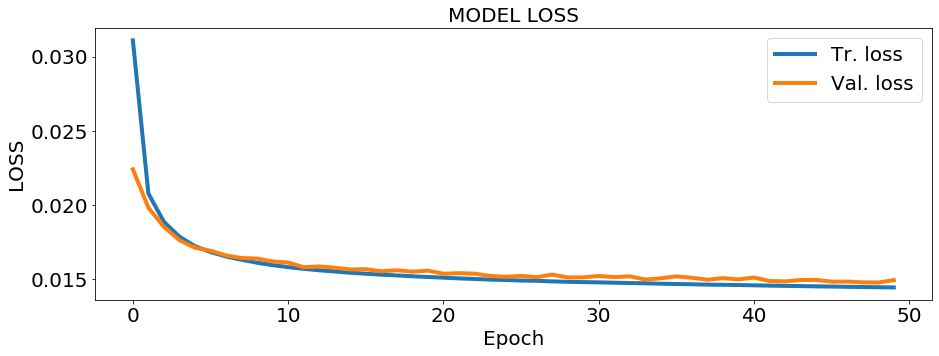

Wall time: 19min 6s


In [18]:
%%time
#Save the model and print the loss 
history = model.fit(x_train_noisy,y_train_no_noise, epochs=50, 
                   verbose=0,batch_size=256, 
                    validation_data=(x_valid_noisy,y_valid_no_noise),
                     callbacks=callback)


#save_model(model, model_file_name='Denoising_AE_model.h5')
print(history.history.keys())
graphHistory(history, title='',metrics=['loss'],linewidth=4,figsize=(15,5),
                    tick_size=20,fontsize=20)

In [19]:
x_train_noisy = []
x_valid_noisy = []
y_train_no_noise = []
y_valid_no_noise = []
X_train_noised = []

In [20]:
#Load model 
model = loadmodel('Denoising_AE_model.h5')

Loaded trained model from saved_models\Denoising_AE_model.h5 


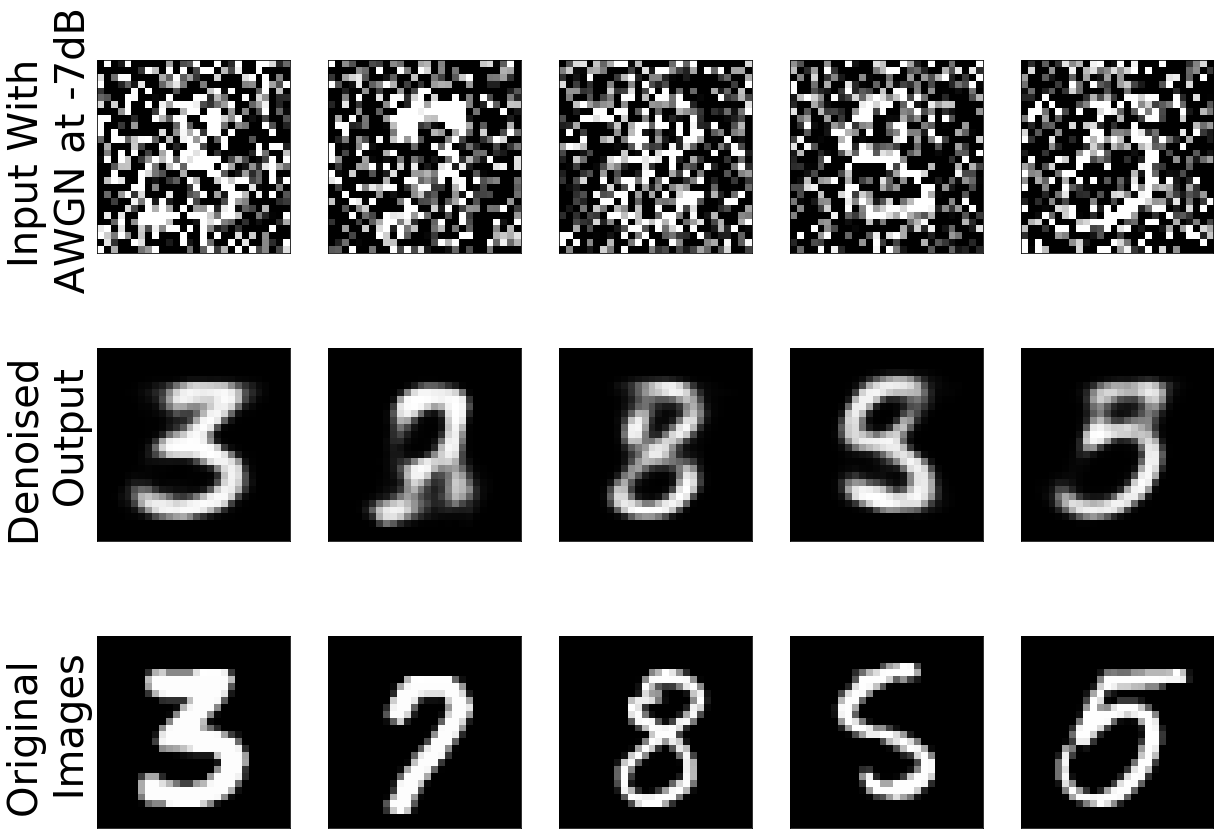

In [33]:
def test_denoiser(X_test_noised, output ):
    fig, ((ax1, ax2, ax3, ax4, ax5), 
          (ax6, ax7, ax8, ax9, ax10), 
          (ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5, figsize=(20,15))

    randomly_selected_imgs = rnd.sample(range(output.shape[0]),5)

    # 1st row for Noising images
    for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
        ax.imshow(X_test_noised[randomly_selected_imgs[i]].reshape(28,28), cmap='gray')
        if i == 0:
            ax.set_ylabel("Input With \n AWGN at {}dB".format(snr),fontsize=40)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # 2nd row for denoised images
    for i, ax in enumerate([ax6,ax7,ax8,ax9,ax10]):    
        ax.imshow(output[randomly_selected_imgs[i]].reshape(28,28), cmap='gray')
        if i == 0:
            ax.set_ylabel("Denoised \n Output",fontsize=40)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])


    # 3rd row for input images
    for i, ax in enumerate([ax11,ax12,ax13,ax14,ax15]):
        ax.imshow(X_test_reshaped[randomly_selected_imgs[i]].reshape(28,28), cmap='gray')
        if i == 0:
            ax.set_ylabel("Original \n Images",fontsize=40)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Plot output
snr = -7
X_test_noised = AWGN(X_test_reshaped, snr=snr)
output = model.predict(X_test_noised)
test_denoiser(X_test_noised, output )

# Remember that to avoid the auto-encoder from learning meaning less patterns you should use regularization. 
